In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

In [2]:
!pwd

/app/notebooks


In [3]:
wind_path = Path('../data/raw/NREL_Wind_Ordinances.xlsx')
solar_path = Path('../data/raw/NREL_Solar_Ordinances.xlsx')
assert wind_path.exists
assert solar_path.exists

In [4]:
wind = pd.read_excel(wind_path, sheet_name="County, State")
solar = pd.read_excel(solar_path, sheet_name="County, State")

/app/.local/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [5]:
wind.head()

State City/Town    County   Feature Type                  Value Type  \
0  Alabama       NaN   Baldwin         Banned                         NaN   
1  Alabama       NaN  Cherokee          Sound                         dBA   
2  Alabama       NaN  Cherokee  Property Line                      Meters   
3  Alabama       NaN  Cherokee   Transmission  Max tip-height Multiplier    
4  Alabama       NaN    Dekalb          Sound                         dBA   

  Value                                    Citation  \
0   NaN  Baldwin County Zoning Ordinance Sec. 13.13   
1    40                    Ala. Code § 45-10-260.05   
2   782                    Ala. Code § 45-10-260.05   
3   1.5                    Ala. Code § 45-10-260.05   
4    40                    Ala. Code § 45-25-260.05   

                                             Comment Updated Type  \
0                                                NaN          NaN   
1                                                NaN          NaN   
2                                                NaN          NaN   
3  Minimum Setback of 1.5 the max height to an ov...          NaN   
4                                                NaN          NaN   

   Updated Value Updated Comment  Ordinance Year  Original Captured Date  \
0            NaN             NaN             NaN                  2018.0   
1            NaN             NaN             NaN                  2021.0   
2            NaN             NaN             NaN                  2021.0   
3            NaN             NaN             NaN                  2021.0   
4            NaN             NaN             NaN                  2021.0   

   New Capture Date Update Status  
0               NaN     No Change  
1               NaN           NaN  
2               NaN           NaN  
3               NaN           NaN  
4               NaN           NaN

## Data Cleaning
- [ ] Accuracy
- [x] Atomicity
- [x] Consistency
- [x] Completeness
- [x] Uniformity
- [x] Validity
    - [x] Range Validation
    - [x] Uniqueness Validation
    - [x] Set Membership Validation
    - [x] Type Validation
    - [x] Cross-Field Validation

## Accuracy
Spot check a few values by googling for permitting restrictions. Checkbox indicates the restriction is present in the NREL database.

#### Douglas County, Kansas
[Wind regulation source](https://www.douglascountyks.org/sites/default/files/media/depts/administration/pdf/county-code-chapter-12-zoning-and-land-use-regulations.pdf#page=107) and [solar regulation source](https://www.jocogov.org/sites/default/files/files/2022-05/Douglas%20County%20Solar%20Regulations%20-%20FINAL.pdf)

Wind:
- [x] property line setback of 1.1x total height 
- [x] 1500 feet from residential structure [NREL does not specify "residential"]
- [ ] blades must be at least 100 feet off the ground at lowest point

Solar: not present in database
- [ ] height limit of 15 feet
- [ ] size limit of 1000 acres
- [ ] ground must maintain vegetation cover
- [ ] residential setback of 500 feet
- [ ] 60dBA noise limit at 500 feet
#### Hughes County, South Dakota
Not present in NREL database. Many other SD counties are, but not this one. [Source](https://hughescounty.org/media/cmshughescountyorg/web_images/zoning/1997-03%20article%202%20exceptions.pdf) These exact ordinances *are* present in the adjacent Hyde county

Wind:
- [ ] Established dwelling – The greater of 2,640 feet or 4.9 times the tower height unless written permission obtained from landowners, in which case the minimum is 1400 feet.
- [ ] County roads – the greater of 750 feet or 1.4 times the system height
- [ ] Exterior boundary – greater of 500 feet or 1.1 times the system height.
- [ ] 45dBA from residences

#### Navajo County, AZ
[Wind](https://www.navajocountyaz.gov/Portals/0/Departments/Planning%20and%20Zoning/Documents/Zoning/Navajo%20County%20Zoning%20Ordinance%20-%202019%20.pdf?ver=2019-11-26-164059-347): 
- [x] Sound: 45dBa to residential
- [x] residential setback: 1/2 mile
- [ ] property line: 1/4 mile to private land > 2.5 acres, 1/2 mile to private land <= 2.5 acres, 1.1x system height otherwise [NREL only has the 1.1x part]
- [x] roadways: 1/4 mile
- [x] rail, transmission: 1.5x system height

Solar:
No specific regulations, currently available only through Special Use permits from the county.

#### Marlboro County
[Source](https://marlborocounty.sc.gov/sites/marlborocounty/files/Documents/%23%20818%20-%20Conditions%20for%20Solar%20Energy%20Systems.pdf)
Solar:
- [ ] max capacity: 75 MW (or is that merely their definition? hard to interpret)
- [x] height: max 25 feet
- [x] property line setback: 100 feet
- [x] residence setback: 400 feet
- [ ] water setback: 50 feet

Wind: not present in database
- [ ] max capacity 75 MW (or is that merely their definition? hard to interpret)

## Atomicity
"Value" column has some multivalued entries, eg. sound levels that depend on time of day. Maybe model this with a simplified version and an indicator column letting you know to check the description for full details.

In [6]:
pd.to_numeric(wind['Value'])

ValueError: Unable to parse string "55/50/45" at position 28

In [7]:
# 6 (0.3%) multivalued entries
wind['Value'].str.contains('/').fillna(False).agg(['sum', 'mean'])

sum     6.000000
mean    0.003273
Name: Value, dtype: float64

In [8]:
wind[wind['Value'].str.contains('/').fillna(False)]

State City/Town           County Feature Type Value Type     Value  \
28    California       NaN            Butte        Sound        dBA  55/50/45   
72    California       NaN  San Luis Obispo        Sound        dBa     70/65   
78    California       NaN           Tehama        Sound        dBa     50/45   
114     Colorado       NaN          Lincoln        Sound        dBA     60/50   
141     Florida        NaN         Osceola         Sound        dBA     55/45   
1103    Nebraska       NaN        Hamilton         Sound        dBA     37/40   

                                               Citation  \
28    Butte County Code § 24-157(E); Butte County Co...   
72    San Luis Obispo County Code § 22.32.060(d)(4);...   
78                       Tehama County Code § 17.83.080   
114       Lincoln County Zoning Resolution 3-210 (F)(7)   
141                        Osceola County Code § 3.9(G)   
1103             Hamilton County Zoning Regs. § 8.08.07   

                                                Comment Updated Type  \
28    55 dbA daytime; 50 dBa evening (7-10pm); 45 db...          NaN   
72    70 dBa maximum daytime (7am-10pm), 65 dBa Nigh...          NaN   
78                    50 dBa Day time/ 45 dBa Nighttime          NaN   
114   60 dBa daytime (7am to 7pm) 50 dBa nighttime (...          NaN   
141   55 dBa daytime (7am to sunset) 45 dBa nighttim...          NaN   
1103       37 dB from 8pm to 8am; 40 dB from 8am to 8pm          NaN   

      Updated Value Updated Comment  Ordinance Year  Original Captured Date  \
28              NaN             NaN             NaN                  2021.0   
72              NaN             NaN             NaN                  2021.0   
78              NaN             NaN             NaN                  2021.0   
114             NaN             NaN             NaN                  2021.0   
141             NaN             NaN             NaN                  2021.0   
1103            NaN             NaN          2019.0                  2022.0   

      New Capture Date Update Status  
28                 NaN           NaN  
72                 NaN           NaN  
78                 NaN           NaN  
114                NaN           NaN  
141                NaN           NaN  
1103               NaN           NaN

In [158]:
wind.loc[wind['Value'].str.contains('/').fillna(False), "Value"].str.split('/', expand=True).apply(pd.to_numeric, axis=1).max(axis=1)

28      55.0
72      70.0
78      50.0
114     60.0
141     55.0
1103    40.0
dtype: float64

In [9]:
pd.to_numeric(solar['Value'])

ValueError: Unable to parse string "22.86/60.96" at position 52

In [10]:
# 5 (0.6%) multivalued entries
solar['Value'].str.contains('/').fillna(False).agg(['sum', 'mean'])

sum     5.000000
mean    0.005967
Name: Value, dtype: float64

In [11]:
solar[solar['Value'].str.contains('/').fillna(False)]

State City/Town       County   Feature Type Value Type        Value  \
52   Florida        NaN         Leon  Property Line    Meters   22.86/60.96   
53   Florida        NaN         Leon          Roads     Meters  22.86/60.96   
54   Florida        NaN         Leon     Structures     Meters  22.86/60.96   
60   Florida        NaN  Palm Beach   Property Line     Meters       7.62/5   
730      Utah       NaN         Kane          Sound        dBA        65/50   

                                              Citation  \
52        Leon County Land Development Code § 10-6.820   
53        Leon County Land Development Code § 10-6.820   
54        Leon County Land Development Code § 10-6.820   
60   Palm Beach Unified Development Land Code § 7(C...   
730                    Kane County Code Ords. § 9-24-3   

                                               Comment  Updated Type  \
52   75' setback if facility is less than 50 acres,...           NaN   
53                                           See above           NaN   
54                                           See above           NaN   
60   25 foot setback if lot size is greater than 50...           NaN   
730  65 db at property line; 50 db at nearest resid...           NaN   

     Updated Value  Updated Comment  Ordinance Year  Original Captured Date  \
52             NaN              NaN             NaN                  2021.0   
53             NaN              NaN             NaN                  2021.0   
54             NaN              NaN             NaN                  2021.0   
60             NaN              NaN             NaN                  2021.0   
730            NaN              NaN          2013.0                     NaN   

     New Capture Date  Update Status  
52                NaN            NaN  
53                NaN            NaN  
54                NaN            NaN  
60                NaN            NaN  
730               NaN            NaN

## Consistency (vs other datasets in our database)
* replace county names with standard census names
* political jurisdictions need IDs to join with the rest of the datasets
* what to do with city/towns? They don't have FIPS codes
* wind and solar datasets look consistent with each other

## Completeness
* wind:
    * brownsville is missing its state (should be TX)
    * Cochise, AZ values weren't entered (present in comment but not in "Value" column)
* solar:
    * Lee County is missing its state (should be GA)

In [12]:
wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1833 entries, 0 to 1832
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   1832 non-null   object 
 1   City/Town               105 non-null    object 
 2   County                  1736 non-null   object 
 3   Feature Type            1833 non-null   object 
 4   Value Type              1776 non-null   object 
 5   Value                   1776 non-null   object 
 6   Citation                1833 non-null   object 
 7   Comment                 261 non-null    object 
 8   Updated Type            12 non-null     object 
 9   Updated Value           11 non-null     float64
 10  Updated Comment         12 non-null     object 
 11  Ordinance Year          484 non-null    float64
 12  Original Captured Date  1816 non-null   float64
 13  New Capture Date        242 non-null    float64
 14  Update Status           228 non-null    

In [13]:
wind.loc[wind['State'].isna(),:]

State    City/Town County Feature Type Value Type Value  \
1656   NaN  Brownsville    NaN       Banned        NaN   NaN   

                                               Citation  \
1656  Code of ordinances Division 2 - Wind Energy Sy...   

                                                Comment Updated Type  \
1656  WECs only used as secondary use; cannot exceed...          NaN   

      Updated Value Updated Comment  Ordinance Year  Original Captured Date  \
1656            NaN             NaN             NaN                  2022.0   

      New Capture Date Update Status  
1656               NaN           NaN

In [14]:
# null "Value" entries are almost all bans. Makes sense.
# Cochise, AZ has setbacks that weren't properly entered.
wind.loc[wind['Value'].isna(),"Feature Type"].str.strip().value_counts(dropna=False)

Banned           54
Property Line     1
Roads             1
Moratorium        1
Name: Feature Type, dtype: int64

In [15]:
solar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838 entries, 0 to 837
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   837 non-null    object 
 1   City/Town               33 non-null     object 
 2   County                  812 non-null    object 
 3   Feature Type            838 non-null    object 
 4   Value Type              836 non-null    object 
 5   Value                   834 non-null    object 
 6   Citation                838 non-null    object 
 7   Comment                 160 non-null    object 
 8   Updated Type            0 non-null      float64
 9   Updated Value           0 non-null      float64
 10  Updated Comment         0 non-null      float64
 11  Ordinance Year          194 non-null    float64
 12  Original Captured Date  284 non-null    float64
 13  New Capture Date        0 non-null      float64
 14  Update Status           0 non-null      fl

In [16]:
solar.loc[solar['State'].isna(),:]

State City/Town County Feature Type Value Type  Value  \
107   NaN       NaN    Lee   Structures     Meters  30.48   

                                   Citation Comment  Updated Type  \
107  Lee County Code of Ordinances § 70-694     NaN           NaN   

     Updated Value  Updated Comment  Ordinance Year  Original Captured Date  \
107            NaN              NaN             NaN                     NaN   

     New Capture Date  Update Status  
107               NaN            NaN

In [17]:
solar.loc[solar['County'].isna() & solar['City/Town'].isna(),:]

Empty DataFrame
Columns: [State, City/Town, County, Feature Type, Value Type, Value, Citation, Comment, Updated Type, Updated Value, Updated Comment, Ordinance Year, Original Captured Date, New Capture Date, Update Status]
Index: []

In [18]:
# null "Value" entries are all bans. Makes sense.
solar.loc[solar['Value'].isna(), :]

State City/Town      County Feature Type Value Type Value  \
4      Arizona        NaN      Pinal        Banned       N/a    NaN   
34     Colorado       NaN  Washington   Moratorium        N/a   NaN   
455   Minnesota       NaN     Wright   Moratorium         NaN   NaN   
818  Washington       NaN       Grant       Banned        NaN   NaN   

                                 Citation  \
4         Pinal Cnty. Ord. § 2.210.030(A)   
34   Washington County Resolution 64-2020   
455     Wright County Amendment Ord. 21-1   
818       Grant County Ord. No. 21-080-CC   

                                               Comment  Updated Type  \
4    Solar PV is restricted from being the primary ...           NaN   
34                                                 NaN           NaN   
455  Moratorium on Commercial Solar as of May 18, 2021           NaN   
818  Six month moratorium beginning in august 2021(...           NaN   

     Updated Value  Updated Comment  Ordinance Year  Original Captured Date  \
4              NaN              NaN             NaN                  2021.0   
34             NaN              NaN             NaN                     NaN   
455            NaN              NaN             NaN                  2018.0   
818            NaN              NaN          2021.0                     NaN   

     New Capture Date  Update Status  
4                 NaN            NaN  
34                NaN            NaN  
455               NaN            NaN  
818               NaN            NaN

## Uniformity
* string values need whitespace stripped
* replace "N/a" with NaN (watch out for whitespace)
* fix a handful of erroneous unit conversions
* some "Updated Type" entries look like misplaced comments
* Looking in Excel, the "Updated" columns have inconsistent formatting and will need some wrangling.

#### NaN values
Pandas automatically converts many common NaN representations, but the mixed capitalization of "N/a" seems to have fooled it

In [19]:
other_nan_values = {'n/a', 'none'}

In [20]:
solar['Value Type'].str.strip().str.lower().isin(other_nan_values).sum()

2

In [21]:
solar.eq('N/a').sum(axis=0)

State                     0
City/Town                 0
County                    0
Feature Type              0
Value Type                1
Value                     0
Citation                  0
Comment                   0
Updated Type              0
Updated Value             0
Updated Comment           0
Ordinance Year            0
Original Captured Date    0
New Capture Date          0
Update Status             0
dtype: int64

In [22]:
wind.eq('N/a').sum(axis=0)

State                     0
City/Town                 0
County                    0
Feature Type              0
Value Type                0
Value                     0
Citation                  0
Comment                   0
Updated Type              0
Updated Value             0
Updated Comment           0
Ordinance Year            0
Original Captured Date    0
New Capture Date          0
Update Status             0
dtype: int64

#### Distances in Meters vs Feet

In [23]:
feet = wind["Comment"].str.lower().str.extract(".*?(\d*,?\d+\.?\d*)(?:'| feet).*").squeeze().str.replace(',', '').astype(float)
is_distance = wind["Value Type"].str.lower().eq("meters")

In [24]:
is_distance.sum()

510

In [25]:
# not great coverage
feet.loc[is_distance].count()

88

In [26]:
ratios = feet.loc[is_distance].div(wind.loc[is_distance, "Value"].astype(float).values)

In [27]:
# feet_per_meter
100 / 2.54 / 12

3.2808398950131235

<AxesSubplot: >

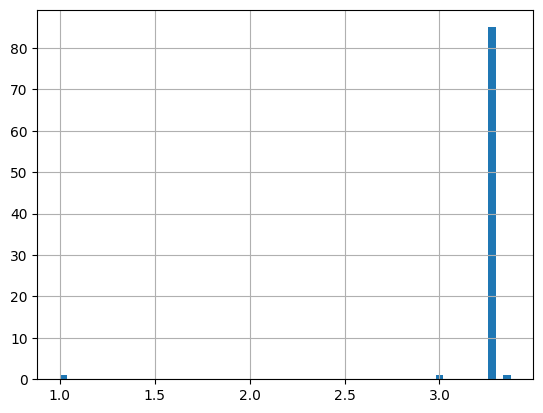

In [28]:
# most look good
ratios.hist(bins=60)

In [29]:
errors = ratios[ratios.lt(3.2) | ratios.gt(3.35)]
errors

26     3.375959
46     3.003003
647    1.000000
Name: 0, dtype: float64

In [30]:
# Only three errors: one is small, one in yards, one in feet
wind.loc[errors.index,:]

State City/Town   County Feature Type Value Type Value  \
26     Arizona        NaN   Navajo   Structures     Meters   782   
46   California       NaN   Lassen       Height     Meters  33.3   
647        Iowa       NaN  Johnson   Structures     Meters  1000   

                                  Citation  \
26   Navajo County Ord. Art 20, 6-10(4)(w)   
46      Lassen County Code § 18.108.280(1)   
647       Johnson County Dev. Ord. § 8:5.8   

                                               Comment Updated Type  \
26   Setback is minimum half mile (2640 Feet) to re...          NaN   
46       Maximum Height of 100 feet without use permit          NaN   
647    Greater of 1000' setback or 1.1 max tip height           NaN   

     Updated Value Updated Comment  Ordinance Year  Original Captured Date  \
26             NaN             NaN             NaN                  2021.0   
46             NaN             NaN             NaN                  2021.0   
647            NaN             NaN             NaN                  2021.0   

     New Capture Date Update Status  
26                NaN           NaN  
46                NaN           NaN  
647               NaN           NaN

Now for solar

In [31]:
feet = solar["Comment"].str.lower().str.extract(".*?(\d*,?\d+\.?\d*)(?:'| feet).*").squeeze().str.replace(',', '').astype(float)
is_distance = solar["Value Type"].str.lower().eq("meters")

In [32]:
is_distance.sum()

703

In [33]:
# not great coverage
feet.loc[is_distance].count()

132

In [34]:
ratios = feet.loc[is_distance].div(pd.to_numeric(solar.loc[is_distance, "Value"], errors='coerce').values)

<AxesSubplot: >

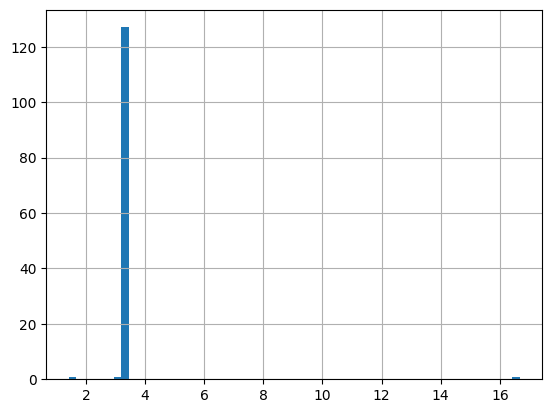

In [35]:
# most look good
ratios.hist(bins=60)

In [36]:
errors = ratios[ratios.lt(3.2) | ratios.gt(3.35)]
errors

6       1.415094
126     3.000000
130    16.666667
476     3.199692
479     3.199692
Name: 0, dtype: float64

In [37]:
# parsing error, yards, parsing error, rounding, rounding
solar.loc[errors.index,:]

State City/Town    County   Feature Type Value Type  Value  \
6    California        NaN     Butte  Property Line     Meters   10.6   
126     Illinois       NaN    Adams          Height     Meters     10   
130     Illinois       NaN   Carroll  Property Line     Meters      6   
476     Nebraska       NaN  Madison           Roads     Meters  25.94   
479     Nebraska       NaN    Pierce          Roads     Meters  25.94   

                                 Citation  \
6          Butte County Code § 24-157(c)    
126     Adams County Code Ord. § 5-7-3(c)   
130        Carroll County Code § 725.1(f)   
476  Madison County Zoning Regs. § 603(C)   
479  Pierce County Zoning Regs. § 6.04.01   

                                               Comment  Updated Type  \
6    20 foot setback plus an additional 15' adjacen...           NaN   
126                                    30' Max Height            NaN   
130  20 foot setback unless next to residential zon...           NaN   
476                83' setback to centerline of roads            NaN   
479                83' setback to centerline of roads            NaN   

     Updated Value  Updated Comment  Ordinance Year  Original Captured Date  \
6              NaN              NaN             NaN                  2021.0   
126            NaN              NaN             NaN                  2021.0   
130            NaN              NaN             NaN                  2021.0   
476            NaN              NaN             NaN                  2018.0   
479            NaN              NaN             NaN                  2018.0   

     New Capture Date  Update Status  
6                 NaN            NaN  
126               NaN            NaN  
130               NaN            NaN  
476               NaN            NaN  
479               NaN            NaN

#### Distance formulas: Tip Height multipliers, constants, or both
Setbacks are commonly expressed as either constant distances (eg 100 meters) or as a multiple of turbine max tip height (eg 1.1x). But sometimes they are both, aka a linear equation (eg 1.1x + 20 meters).

* to facilitate computation, the linear expressions should be broken into pieces.

In [38]:
# 22 (1.2%) entries have a linear equation
wind['Value'].str.contains('\+').fillna(False).agg(['sum', 'mean'])

sum     22.000000
mean     0.012002
Name: Value, dtype: float64

In [39]:
wind[wind['Value'].str.contains('\+').fillna(False)].sample(5)

State City/Town     County  Feature Type  \
823         Kansas       NaN     Seward  Transmission   
757         Kansas       NaN      Geary         Roads   
1441  North Dakota       NaN     Oliver         Roads   
770         Kansas       NaN  Jefferson         Roads   
795         Kansas       NaN      Osage         Roads   

                     Value Type             Value  \
823   Max tip-height Multiplier  1 + 12.19 Meters   
757   Max tip-height Multiplier  1 + 15.24 meters   
1441  Max tip-height Multiplier  1 + 22.86 Meters   
770   Max tip-height Multiplier  1 + 15.24 meters   
795   Max tip-height Multiplier   1+ 15.24 Meters   

                                              Citation Comment Updated Type  \
823                       Seward County Zoning Art. 27     NaN          NaN   
757                    Geary County Zoning Regulations     NaN          NaN   
1441                 Section 14 wind energy facilities     NaN          NaN   
770                Jefferson County Zoning Regulations     NaN          NaN   
795   Osage County Wind Energy Ordinance Sec 11-102(5)     NaN          NaN   

      Updated Value Updated Comment  Ordinance Year  Original Captured Date  \
823             NaN             NaN             NaN                  2022.0   
757             NaN             NaN             NaN                  2022.0   
1441            NaN             NaN             NaN                  2022.0   
770             NaN             NaN             NaN                  2022.0   
795             NaN             NaN          2010.0                  2022.0   

      New Capture Date Update Status  
823                NaN           NaN  
757                NaN           NaN  
1441               NaN           NaN  
770                NaN           NaN  
795                NaN           NaN

In [40]:
# no linear solar stuff
solar['Value'].str.contains('\+').fillna(False).agg(['sum', 'mean'])

sum     0.0
mean    0.0
Name: Value, dtype: float64

## Uniqueness Validation
Primary key is row number. The tuple (state, city/town, county, feature type, value type) does not uniquely identify rows because of conditionals buried in the "Comment" field.

For wind:
* there are a few duplicates with conflicting values. Most look like updates (one has a later "Captured Date") so I'll plan to use the latest one.
* one (Allegany County, MD) is a triple-valued conditional. Other rows like that were expressed with a single value "1/2/3"
* Adams and LaSalle IL have multiple structure setbacks conditional on either on/off site or whether they are residential.

For solar:
* a handful of duplicates that differ only in the "updated" columns
* some places have different setbacks conditioned on residential zoning or front/side of parcel

In [41]:
pd.options.display.max_colwidth = None
wind[wind.duplicated(subset=['State', 'City/Town', 'County', 'Feature Type'], keep=False)]

State City/Town          County   Feature Type  \
38   California       NaN            Kern  Property Line   
39   California       NaN            Kern  Property Line   
45   California       NaN          Lassen     Structures   
47   California       NaN          Lassen     Structures   
65   California       NaN  San Bernardino  Property Line   
66   California       NaN  San Bernardino  Property Line   
161    Illinois       NaN           Adams     Structures   
164    Illinois       NaN           Adams     Structures   
268   Illinois        NaN        LaSalle      Structures   
270   Illinois        NaN        LaSalle      Structures   
831    Maryland       NaN        Allegany  Property Line   
832    Maryland       NaN        Allegany  Property Line   
833    Maryland       NaN        Allegany  Property Line   
852    Michigan       NaN           Huron          Roads   
857    Michigan       NaN           Huron          Roads   

                     Value Type   Value  \
38    Max tip-height Multiplier       2   
39    Max tip-height Multiplier     1.5   
45                       Meters       6   
47                       Meters  3.6576   
65    Max tip-height Multiplier       2   
66    Max tip-height Multiplier     1.5   
161                     Meters    402.3   
164  Max tip-height Multiplier      1.1   
268                      Meters  365.76   
270       Hub-height Multiplier     1.5   
831   Max tip-height Multiplier       1   
832   Max tip-height Multiplier       2   
833   Max tip-height Multiplier       3   
852   Max tip-height Multiplier     1.5   
857   Max tip-height Multiplier     1.5   

                                       Citation  \
38              Kern County Code § 19.64.140(F)   
39              Kern County Code § 19.64.140(F)   
45          Lassen County Code § 18.108.280 (2)   
47          Lassen County Code § 18.108.280 (2)   
65   San Bernadino County Dev. Code § 84.29.030   
66   San Bernadino County Dev. Code § 84.29.030   
161                Adams County Code § 5-6-7(f)   
164                Adams County Code § 5-6-7(f)   
268               LaSalle County Ord. § 7.1(RR)   
270               LaSalle County Ord. § 7.1(RR)   
831         Allegany County Zoning sec. 360-107   
832         Allegany County Zoning sec. 360-107   
833         Allegany County Zoning sec. 360-107   
852         Huron County Wind Energy Ordinance    
857         Huron County Wind Energy Ordinance    

                                                                                                                                         Comment  \
38     lesser of 2x max tip height or 500 feet to property line unless owned by same project developer if project is less than 40 acres in size    
39   lesser of 1.5x max tip height or 500 feet to property line unless owned by same project developer if project is more than 40 acres in size    
45                                                                                                                                           NaN   
47                                                                                                                                           NaN   
65                  Setback of 2x max tip height if project is on less than 40 acres, waived if common property line is shared by project owner    
66                Setback of 1.5x max tip height if project is on more than 40 acres, waived if common property line is shared by project owner    
161                                                                                                                  Primary Structures offsite    
164                                                                                                                    Primary structure onsite    
268                                                                                                             1200 foot setback to residences    
270                                                            

In [42]:
solar[solar.duplicated(subset=['State', 'City/Town', 'County', 'Feature Type'], keep=False)]

State City/Town     County   Feature Type Value Type  Value  \
37   Florida        NaN      Clay   Property Line     Meters   7.62   
38   Florida        NaN      Clay   Property Line     Meters  30.48   
50   Florida        NaN  Jefferson  Property Line     Meters  30.48   
51   Florida        NaN  Jefferson  Property Line     Meters  60.96   
219   Indiana       NaN    Clinton  Property Line     Meters  15.24   
220   Indiana       NaN    Clinton     Structures     Meters  60.96   
221   Indiana       NaN    Clinton         Height     Meters  6.096   
226   Indiana       NaN    Clinton  Property Line     Meters  15.24   
227   Indiana       NaN    Clinton     Structures     Meters  60.96   
228   Indiana       NaN    Clinton         Height     Meters  6.096   
505  New York     Lenox        NaN  Property Line     Meters  30.48   
506  New York     Lenox        NaN  Property Line     Meters   76.2   

                                            Citation  \
37       Clay County Land Development Code § 3-2(bo)   
38       Clay County Land Development Code § 3-2(bo)   
50   Jefferson County Land Development Code § 2.11.4   
51   Jefferson County Land Development Code § 2.11.4   
219                      Clinton County Ord. §406.02   
220                      Clinton County Ord. §406.02   
221                      Clinton County Ord. §406.02   
226                      Clinton County Ord. §406.02   
227                      Clinton County Ord. §406.02   
228                      Clinton County Ord. §406.02   
505                      Lenox Town Code § 134-152.9   
506                      Lenox Town Code § 134-152.9   

                                                         Comment  \
37            25' Setbacks if not adjacent to residential zones    
38                 100' setback if adjacent to residential zone    
50   100' landscape buffer from vacant or nonresidential parcels   
51                200' landscape buffer for residential parcels    
219                                                          NaN   
220                                                          NaN   
221                                                          NaN   
226                                                          NaN   
227                                                          NaN   
228                                                          NaN   
505                                  100' rear and side setbacks   
506                                           250' front setback   

     Updated Type  Updated Value  Updated Comment  Ordinance Year  \
37            NaN            NaN              NaN             NaN   
38            NaN            NaN              NaN             NaN   
50            NaN            NaN              NaN             NaN   
51            NaN            NaN              NaN             NaN   
219           NaN            NaN              NaN             NaN   
220           NaN            NaN              NaN             NaN   
221           NaN            NaN              NaN             NaN   
226           NaN            NaN              NaN             NaN   
227           NaN            NaN              NaN             NaN   
228           NaN            NaN              NaN             NaN   
505           NaN            NaN              NaN          2017.0   
506           NaN            NaN              NaN          2017.0   

     Original Captured Date  New Capture Date  Update Status  
37                   2021.0               NaN            NaN  
38                   2021.0               NaN            NaN  
50                   2021.0               NaN            NaN  
51                   2021.0               NaN            NaN  
219                  2022.0               NaN            NaN  
220                  2022.0               NaN            NaN  
221                     NaN               NaN            NaN  
226                     NaN               NaN            NaN  
227  

## Set Membership Validation

#### State
Will check exact values when assigning FIPS codes

In [43]:
# <= 51
wind['State'].nunique()

44

In [44]:
# <= 51
solar['State'].nunique()

36

#### Feature Type
* some mis-spellings and mixed plurals
* bunch of named entities like rivers/lakes/highways

In [45]:
wind['Feature Type'].str.strip().str.lower().value_counts(dropna=False)

structures                   372
property line                353
roads                        344
sound                        219
transmission                 182
height                        91
railroads                     61
banned                        54
water                         35
minimum lot size              22
tower density                 18
density                       15
shadow flicker                13
rivers                         8
highways                       7
total installation             3
missouri river                 3
wabash river                   2
oil & gas pipelines            2
maximum installation size      1
property                       1
lake audubon                   1
lake sakakawea                 1
appalachian trail              1
waccamaw river                 1
pee dee river                  1
lake oahe                      1
highway                        1
black river                    1
north santee river             1
mississipp

In [46]:
solar['Feature Type'].str.strip().str.lower().value_counts(dropna=False)

property line              232
height                     190
structures                 137
roads                      117
minimum lot size            49
sound                       33
highway                     20
maximum lot size            14
waters                       7
density                      5
maximum lot coverage         4
coverage                     4
total installation           4
moratorium                   2
noise                        2
total installation size      2
banned                       2
maximum project size         2
rivers                       2
lakes                        1
mimimum lot size             1
property lines               1
wetlands                     1
sounds                       1
m.d. route 413               1
u.s. route 13                1
railroads                    1
road                         1
lankford highway             1
Name: Feature Type, dtype: int64

#### Value Type
* some mis-spellings and mixed plurals
* mixed "n/a" and NaN

In [47]:
wind['Value Type'].str.strip().str.lower().value_counts(dropna=False)

max tip-height multiplier    928
meters                       516
dba                          218
NaN                           57
rotor-diameter multiplier     28
rotor diameter multiplier     28
acres                         23
hrs/year                      13
hub-height multiplier          8
turbines                       3
kw                             2
meter                          2
turbine count                  1
minimum lot size               1
rotor-radius                   1
max tip-height                 1
rotor diameter mutliplier      1
rotor diameter                 1
max-tip height multiplier      1
Name: Value Type, dtype: int64

In [48]:
solar['Value Type'].str.strip().str.lower().value_counts(dropna=False)

meters                                 706
acres                                   71
dba                                     36
maximum structure height                 9
percentage                               9
n/a                                      2
NaN                                      2
maximum structure height multiplier      1
meter                                    1
megawatt                                 1
Name: Value Type, dtype: int64

#### "Updated Type"
* some misplaced entires that look like they belong in the "comments" column

In [52]:
wind['Updated Type'].str.strip().str.lower().value_counts(dropna=False)

NaN                                                 1821
meters                                                 5
max tip-height multiplier                              3
20 foot setback to any structure on the property       1
prohibition on utility scale wind energy systems       1
max tip height multiplier + ft                         1
dba                                                    1
Name: Updated Type, dtype: int64

In [54]:
# all empty
solar['Updated Type'].value_counts(dropna=False)

NaN    838
Name: Updated Type, dtype: int64

#### Update Status
* many of these look like they should be "Updated Comment"

In [55]:
wind['Update Status'].str.strip().str.lower().value_counts(dropna=False)

NaN                                                        1605
no change                                                   192
changed                                                      13
change from meters to multiplier                              4
changed from 1.1 to 1.5                                       3
changed max tip-height to meters                              1
changed from 50 to 45                                         1
changed from 305 to 457.2                                     1
changed from "highways" to "banned"                           1
changed from 304.5 to 1.1 max tip height                      1
changed from 228.6 to 304.5                                   1
changed from 228.6 to 304.8                                   1
marshall county banned commercial wind in 2013                1
change from 50 to 60 dba                                      1
changed from 160.2 to 182.88 meters                           1
changed from 152 to 213 meters          

In [57]:
# all NaN
solar['Update Status'].value_counts(dropna=False)

NaN    838
Name: Update Status, dtype: int64

## Type Validation

#### Value
Should be numeric, but a few multivalued, equation, or range entries break that assumption.

In [49]:
wind['Value'].str.contains('/').fillna(False).agg(['sum', 'mean'])

sum     6.000000
mean    0.003273
Name: Value, dtype: float64

In [166]:
wind.loc[wind['Value'].str.contains('/').fillna(False),:]

State City/Town           County Feature Type Value Type     Value  \
28    California       NaN            Butte        Sound        dBA  55/50/45   
72    California       NaN  San Luis Obispo        Sound        dBa     70/65   
78    California       NaN           Tehama        Sound        dBa     50/45   
114     Colorado       NaN          Lincoln        Sound        dBA     60/50   
141     Florida        NaN         Osceola         Sound        dBA     55/45   
1103    Nebraska       NaN        Hamilton         Sound        dBA     37/40   

                                                                                     Citation  \
28                                    Butte County Code § 24-157(E); Butte County Code 41A(7)   
72    San Luis Obispo County Code § 22.32.060(d)(4); San Luis Obispo County Code 22.10.120(B)   
78                                                             Tehama County Code § 17.83.080   
114                                             Lincoln County Zoning Resolution 3-210 (F)(7)   
141                                                              Osceola County Code § 3.9(G)   
1103                                                   Hamilton County Zoning Regs. § 8.08.07   

                                                                   Comment  \
28    55 dbA daytime; 50 dBa evening (7-10pm); 45 dba nighttime (10pm-7am)   
72          70 dBa maximum daytime (7am-10pm), 65 dBa Nighttime (10pm-7am)   
78                                       50 dBa Day time/ 45 dBa Nighttime   
114              60 dBa daytime (7am to 7pm) 50 dBa nighttime (7pm to 7am)   
141         55 dBa daytime (7am to sunset) 45 dBa nighttime (Sunset to 7am   
1103                          37 dB from 8pm to 8am; 40 dB from 8am to 8pm   

     Updated Type  Updated Value Updated Comment  Ordinance Year  \
28            NaN            NaN             NaN             NaN   
72            NaN            NaN             NaN             NaN   
78            NaN            NaN             NaN             NaN   
114           NaN            NaN             NaN             NaN   
141           NaN            NaN             NaN             NaN   
1103          NaN            NaN             NaN          2019.0   

      Original Captured Date  New Capture Date Update Status  
28                    2021.0               NaN           NaN  
72                    2021.0               NaN           NaN  
78                    2021.0               NaN           NaN  
114                   2021.0               NaN           NaN  
141                   2021.0               NaN           NaN  
1103                  2022.0               NaN           NaN

In [60]:
wind['Value'].str.contains('\+').fillna(False).agg(['sum', 'mean'])

sum     22.000000
mean     0.012002
Name: Value, dtype: float64

In [167]:
wind.loc[wind['Value'].str.contains('\+').fillna(False),:]

State      City/Town     County   Feature Type  \
102       Colorado            NaN     Elbert  Property Line   
738         Kansas            NaN   Crawford          Roads   
757         Kansas            NaN      Geary          Roads   
770         Kansas            NaN  Jefferson          Roads   
772         Kansas            NaN     Kearny          Roads   
778         Kansas            NaN       Lyon          Roads   
779         Kansas            NaN       Lyon   Transmission   
795         Kansas            NaN      Osage          Roads   
807         Kansas            NaN       Reno  Property Line   
808         Kansas            NaN       Reno          Roads   
821         Kansas            NaN     Seward          Roads   
823         Kansas            NaN     Seward   Transmission   
1242      New York  Cohocton Town        NaN          Roads   
1243      New York  Cohocton Town        NaN  Property Line   
1244      New York  Cohocton Town        NaN   Transmission   
1278      New York  Lowville Town        NaN          Roads   
1423  North Dakota            NaN     McLean  Property Line   
1424  North Dakota            NaN     McLean          Roads   
1433  North Dakota            NaN     Morton          Roads   
1434  North Dakota            NaN     Morton   Transmission   
1441  North Dakota            NaN     Oliver          Roads   
1442  North Dakota            NaN     Oliver   Transmission   

                     Value Type              Value  \
102   Max tip-height Multiplier          1 + 25 ft   
738   Max tip-height Multiplier   1 + 15.24 meters   
757   Max tip-height Multiplier   1 + 15.24 meters   
770   Max tip-height Multiplier   1 + 15.24 meters   
772   Max tip-height Multiplier   1 + 15.24 meters   
778   Max tip-height Multiplier    1+ 22.86 Meters   
779   Max tip-height Multiplier   1 + 12.19 Meters   
795   Max tip-height Multiplier    1+ 15.24 Meters   
807   Max tip-height Multiplier    1+ 15.24 Meters   
808   Max tip-height Multiplier    1+ 15.24 Meters   
821   Max tip-height Multiplier   1 + 22.86 meters   
823   Max tip-height Multiplier   1 + 12.19 Meters   
1242  Max tip-height Multiplier   1 + 30.48 Meters   
1243  Max tip-height Multiplier   2 + 30.48 Meters   
1244  Max tip-height Multiplier   3 + 30.48 Meters   
1278  Max tip-height Multiplier  1.5 + 76.2 Meters   
1423  Max tip-height Multiplier   1 + 22.86 Meters   
1424  Max tip-height Multiplier   1 + 22.86 Meters   
1433  Max tip-height Multiplier   1 + 22.86 Meters   
1434  Max tip-height Multiplier   1 + 22.86 Meters   
1441  Max tip-height Multiplier   1 + 22.86 Meters   
1442  Max tip-height Multiplier   1 + 22.86 Meters   

                                                                   Citation  \
102                            Elbert County Zoning Regulations Art. 5 § 26   
738                                          Crawford County Zoning Art. 16   
757                                         Geary County Zoning Regulations   
770                                     Jefferson County Zoning Regulations   
772                                          Kearny County Zoning Ordinance   
778                       Lyon County Wind Energy Ordinance Art. 8 Sec. 808   
779                       Lyon County Wind Energy Ordinance Art. 8 Sec. 808   
795                        Osage County Wind Energy Ordinance Sec 11-102(5)   
807                  Reno County Zoning Ordinance Art. 23 CWECS Regulations   
808                  Reno County Zoning Ordinance Art. 23 CWECS Regulations   
821                                            Seward County Zoning Art. 27   
823                                            Seward County Zoning Art. 27   
1242                               Cohocton Zoning II. Industrial Windmills   
1243                               Cohocton Zoning II. Industrial Windmills   
1244                               Cohocton Zoning II. Industrial Windmills   
1278  Lowville Zoning § 100-14 Setbacks for wind energy 

In [61]:
wind['Value'].str.contains('or less').fillna(False).agg(['sum', 'mean'])

sum     2.000000
mean    0.001091
Name: Value, dtype: float64

In [59]:
# all the rest work
pd.to_numeric(wind.loc[~wind['Value'].str.contains('/|\+|or less').fillna(False), "Value"])

0         NaN
1        40.0
2       782.0
3         1.5
4        40.0
        ...  
1828     45.0
1829      1.1
1830      1.1
1831      5.5
1832      5.5
Name: Value, Length: 1803, dtype: float64

In [63]:
solar['Value'].str.contains('/').fillna(False).agg(['sum', 'mean'])

sum     5.000000
mean    0.005967
Name: Value, dtype: float64

In [65]:
solar['Value'].str.contains('-').fillna(False).agg(['sum', 'mean'])

sum     1.000000
mean    0.001193
Name: Value, dtype: float64

In [66]:
# all the rest are numeric
pd.to_numeric(solar.loc[~solar['Value'].str.contains('/|-').fillna(False), "Value"])

0       2.000
1       6.100
2      23.000
3       6.100
4         NaN
        ...  
833    60.960
834    30.480
835     4.572
836    10.000
837     4.572
Name: Value, Length: 832, dtype: float64

In [172]:
# all the rest are numeric
(solar.loc[solar['Value'].str.contains('/|-').fillna(False), :])

State City/Town       County   Feature Type Value Type          Value                                            Citation                                                                         Comment  Updated Type  Updated Value  Updated Comment  Ordinance Year  Original Captured Date  New Capture Date  Update Status
52     Florida        NaN         Leon  Property Line    Meters     22.86/60.96        Leon County Land Development Code § 10-6.820   75' setback if facility is less than 50 acres, 200' if greater than 50 acres            NaN            NaN              NaN             NaN                  2021.0               NaN            NaN
53     Florida        NaN         Leon          Roads     Meters    22.86/60.96        Leon County Land Development Code § 10-6.820                                                                       See above           NaN            NaN              NaN             NaN                  2021.0               NaN            NaN
54     Florida        NaN         Leon     Structures     Meters    22.86/60.96        Leon County Land Development Code § 10-6.820                                                                       See above           NaN            NaN              NaN             NaN                  2021.0               NaN            NaN
60     Florida        NaN  Palm Beach   Property Line     Meters         7.62/5  Palm Beach Unified Development Land Code § 7(C)(8)  25 foot setback if lot size is greater than 50 Acres/15' if less than 50 acres           NaN            NaN              NaN             NaN                  2021.0               NaN            NaN
730        Utah       NaN         Kane          Sound        dBA          65/50                     Kane County Code Ords. § 9-24-3                             65 db at property line; 50 db at nearest residence            NaN            NaN              NaN          2013.0                     NaN               NaN            NaN
821  Washington       NaN    Klickitat     Structures     Meters  152.4 - 457.2              Klickitat County Code Ords. § 19.39:8        Range of setbacks ranging from 500-1500 feet based on geographic factors            NaN            NaN              NaN          2010.0                     NaN               NaN            NaN

#### Ordinance Year
all numeric

In [79]:
# All valid years or missing
pd.to_datetime(wind['Ordinance Year'], format='%Y')

0      NaT
1      NaT
2      NaT
3      NaT
4      NaT
        ..
1828   NaT
1829   NaT
1830   NaT
1831   NaT
1832   NaT
Name: Ordinance Year, Length: 1833, dtype: datetime64[ns]

In [80]:
# All valid years or missing
pd.to_datetime(solar['Ordinance Year'], format='%Y')

0     NaT
1     NaT
2     NaT
3     NaT
4     NaT
       ..
833   NaT
834   NaT
835   NaT
836   NaT
837   NaT
Name: Ordinance Year, Length: 838, dtype: datetime64[ns]

#### Original Captured Date


In [74]:
# All valid years or missing
pd.to_datetime(wind['Original Captured Date'], format="%Y")

0      2018-01-01
1      2021-01-01
2      2021-01-01
3      2021-01-01
4      2021-01-01
          ...    
1828   2022-01-01
1829   2022-01-01
1830   2022-01-01
1831   2022-01-01
1832   2022-01-01
Name: Original Captured Date, Length: 1833, dtype: datetime64[ns]

In [75]:
# All valid years or missing
pd.to_datetime(solar['Original Captured Date'], format="%Y")

0     2021-01-01
1     2021-01-01
2     2021-01-01
3     2021-01-01
4     2021-01-01
         ...    
833          NaT
834          NaT
835          NaT
836          NaT
837          NaT
Name: Original Captured Date, Length: 838, dtype: datetime64[ns]

#### New Capture Date

In [76]:
# All valid years or missing
pd.to_datetime(wind['New Capture Date'], format="%Y")

0      NaT
1      NaT
2      NaT
3      NaT
4      NaT
        ..
1828   NaT
1829   NaT
1830   NaT
1831   NaT
1832   NaT
Name: New Capture Date, Length: 1833, dtype: datetime64[ns]

In [77]:
# All valid years or missing
pd.to_datetime(solar['New Capture Date'], format="%Y")

0     NaT
1     NaT
2     NaT
3     NaT
4     NaT
       ..
833   NaT
834   NaT
835   NaT
836   NaT
837   NaT
Name: New Capture Date, Length: 838, dtype: datetime64[ns]

## Range Validation

#### Ordinance Year

<AxesSubplot: >

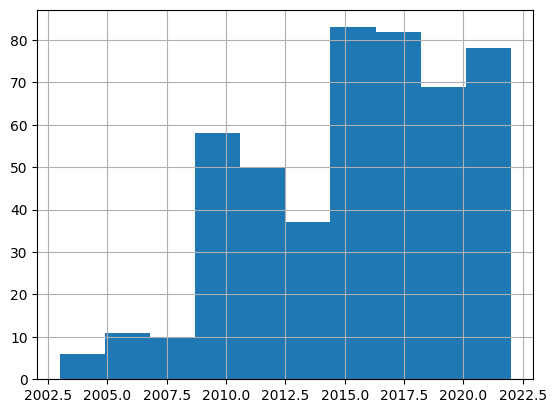

In [81]:
# All valid years or missing
pd.to_datetime(wind['Ordinance Year'], format='%Y').dt.year.hist()

<AxesSubplot: >

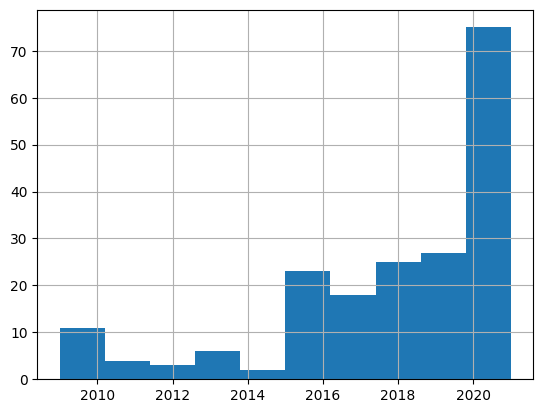

In [82]:
# All valid years or missing
pd.to_datetime(solar['Ordinance Year'], format='%Y').dt.year.hist()

#### Original Captured Date


<AxesSubplot: >

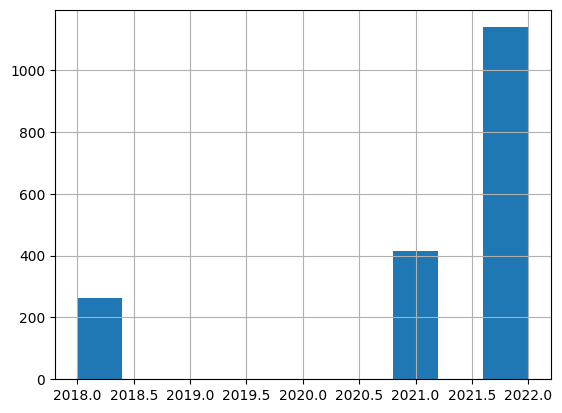

In [83]:
# All valid years or missing
pd.to_datetime(wind['Original Captured Date'], format="%Y").dt.year.hist()

<AxesSubplot: >

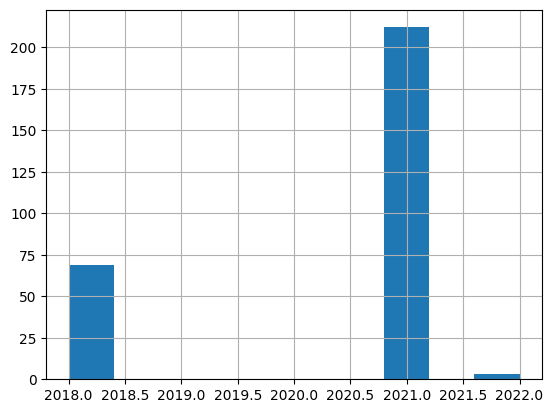

In [84]:
# All valid years or missing
pd.to_datetime(solar['Original Captured Date'], format="%Y").dt.year.hist()

#### New Capture Date

<AxesSubplot: >

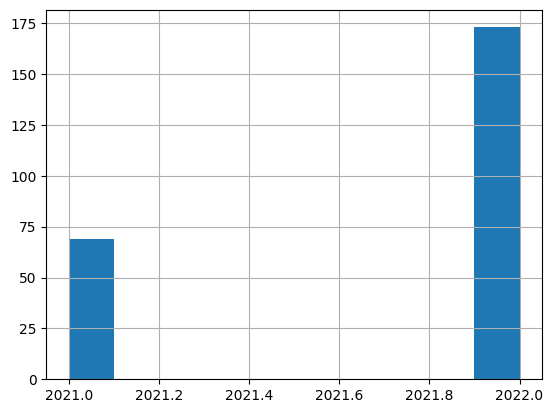

In [85]:
# All valid years or missing
pd.to_datetime(wind['New Capture Date'], format="%Y").dt.year.hist()

<AxesSubplot: >

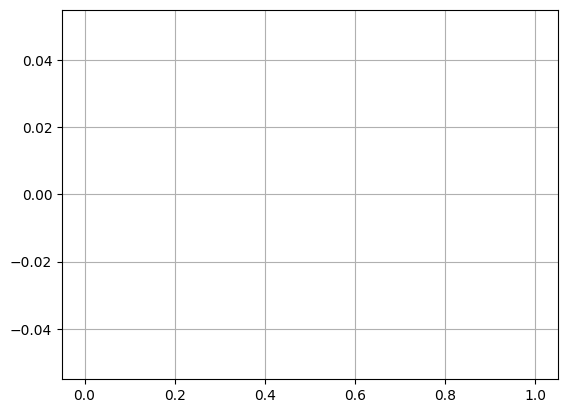

In [86]:
# All valid years or missing
pd.to_datetime(solar['New Capture Date'], format="%Y").dt.year.hist()

#### Value

<AxesSubplot: >

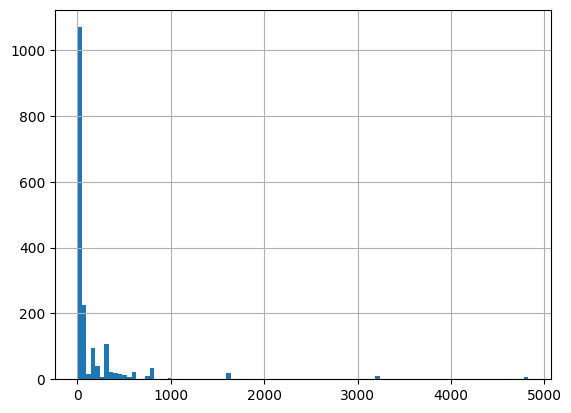

In [88]:
# ignore the handful of weird values for now
pd.to_numeric(wind.loc[~wind['Value'].str.contains('/|\+|or less').fillna(False), "Value"]).hist(bins=100)

<AxesSubplot: >

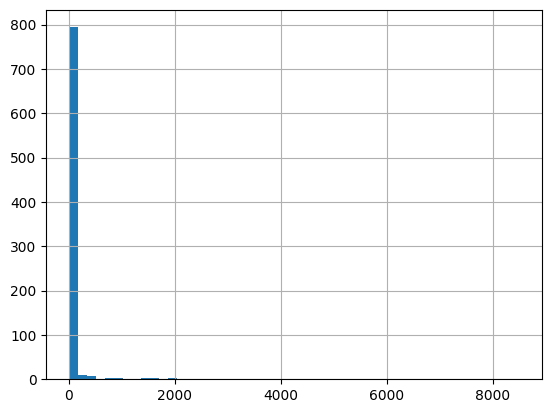

In [89]:
# ignore the handful of weird values for now
pd.to_numeric(solar.loc[~solar['Value'].str.contains('/|-').fillna(False), "Value"]).hist(bins=50)

## Cross-Field Validation
New Capture Date >= Original Capture Date >= Ordinance Year
* poor date modeling by NREL makes these values hard to interpret
* Some "Original Capture Date"s are less than "Ordinance Year" even when "New Capture Date" is null, indicating no update has occured.
* wind: some Ordinance year appear to have been updated (between orignal and new capture dates) even though there are no entries for other update columns

In [140]:
# fill with dates that satisfy the condition. This is because comparisions with NaN output False, but I want them to produce True
ord_yr_wind = pd.to_datetime(wind['Ordinance Year'], format='%Y').fillna(pd.Timestamp('1990-01-01'))
orig_cap_yr_wind = pd.to_datetime(wind['Original Captured Date'], format='%Y').fillna(ord_yr_wind)
new_cap_yr_wind = pd.to_datetime(wind['New Capture Date'], format='%Y').fillna(new_cap_yr_wind)

In [144]:
ord_yr_solar = pd.to_datetime(solar['Ordinance Year'], format='%Y').fillna(pd.Timestamp('1990-01-01'))
orig_cap_yr_solar = pd.to_datetime(solar['Original Captured Date'], format='%Y').fillna(ord_yr_solar)
new_cap_yr_solar = pd.to_datetime(solar['New Capture Date'], format='%Y').fillna(new_cap_yr_solar)

<AxesSubplot: >

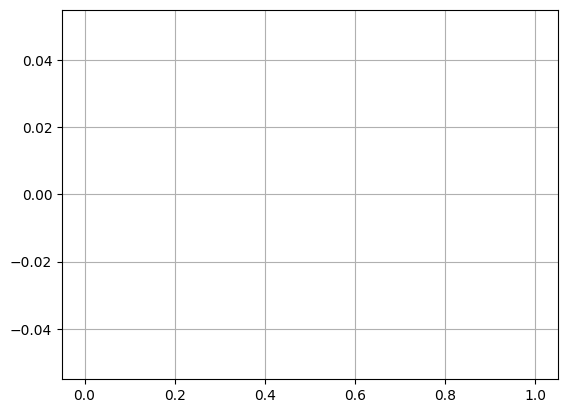

In [132]:
# All valid years or missing
pd.to_datetime(solar['New Capture Date'], format="%Y").dt.year.hist()

In [141]:
new_cap_yr_wind.ge(orig_cap_yr_wind).all()

True

In [145]:
new_cap_yr_solar.ge(orig_cap_yr_solar).all()

True

In [146]:
orig_cap_yr_wind.ge(ord_yr_wind).all()

False

In [147]:
wind[~orig_cap_yr_wind.ge(ord_yr_wind)]

State City/Town      County  Feature Type  \
1325  North Carolina       NaN   Currituck        Banned   
1628    South Dakota       NaN  Pennington  Transmission   
1629    South Dakota       NaN  Pennington         Roads   
1630    South Dakota       NaN  Pennington    Structures   
1631    South Dakota       NaN  Pennington         Sound   

                     Value Type Value  \
1325                        NaN   NaN   
1628  Max tip-height Multiplier   1.5   
1629  Max tip-height Multiplier   1.5   
1630  Max tip-height Multiplier   1.5   
1631                        dBA    55   

                                                                                       Citation  \
1325  In 2019, Carrituck County amended the UDO to prohibit large scale wind energy facilities    
1628                                                  Pennington County Zoning Ord. § 317(B)(5)   
1629                                                  Pennington County Zoning Ord. § 317(B)(5)   
1630                                                  Pennington County Zoning Ord. § 317(B)(5)   
1631                                                  Pennington County Zoning Ord. § 317(B)(5)   

     Comment Updated Type  Updated Value Updated Comment  Ordinance Year  \
1325     NaN          NaN            NaN             NaN          2019.0   
1628     NaN          NaN            NaN             NaN          2021.0   
1629     NaN          NaN            NaN             NaN          2021.0   
1630     NaN          NaN            NaN             NaN          2021.0   
1631     NaN          NaN            NaN             NaN          2021.0   

      Original Captured Date  New Capture Date  \
1325                  2018.0            2022.0   
1628                  2018.0            2022.0   
1629                  2018.0            2022.0   
1630                  2018.0            2022.0   
1631                  2018.0            2022.0   

                            Update Status  
1325  Changed from "Highways" to "Banned"  
1628             Changed from 1.1 to 1.5   
1629             Changed from 1.1 to 1.5   
1630             Changed from 1.1 to 1.5   
1631                            No change

In [148]:
orig_cap_yr_solar.ge(ord_yr_solar).all()

False

In [149]:
solar[~orig_cap_yr_solar.ge(ord_yr_solar)]

State City/Town    County       Feature Type Value Type  \
458         Missouri       NaN    Warren         Structures     Meters   
459         Nebraska       NaN      Cass      Property Line     Meters   
460         Nebraska       NaN      Cass             Height     Meters   
463         Nebraska       NaN    Dawson      Property Line     Meters   
464         Nebraska       NaN    Dawson             Height     Meters   
467         Nebraska       NaN  Hamilton      Property Line     Meters   
468         Nebraska       NaN  Hamilton             Height     Meters   
472         Nebraska       NaN   Kearney           Wetlands     Meters   
473         Nebraska       NaN   Kimball      Property Line     Meters   
474         Nebraska       NaN   Kimball         Structures     Meters   
519  North Carolina        NaN  Alamance  Minimum Lot Size       Acres   
520  North Carolina        NaN  Alamance      Property Line     Meters   
535  North Carolina        NaN    Camden   Minimum Lot Size      Acres   
536  North Carolina        NaN    Camden      Property Line     Meters   
537  North Carolina        NaN    Camden             Height     Meters   

      Value                                       Citation  \
458   60.96     Warren County Dev. Code Appdx D. § 4(A)(2)   
459   9.144             Cass County Zoning Regs. § 8.21.05   
460    7.62             Cass County Zoning Regs. § 8.21.05   
463   9.144           Dawson County Zoning Regs. § 6.09.05   
464    3.65           Dawson County Zoning Regs. § 6.09.05   
467   9.144         Hamilton County Zoning Regs. § 8.09.06   
468    3.65         Hamilton County Zoning Regs. § 8.09.06   
472  402.33          Kearney County Zoning Regs. § 7.42.12   
473   15.24          Kimball County Zoning Regs. § 20.04.4   
474   30.48          Kimball County Zoning Regs. § 20.04.4   
519      10      Alamance County Unified Dev. Ord. § 6.8.3   
520   22.86      Alamance County Unified Dev. Ord. § 6.8.3   
535       5  Camden County Unified Dev. Ord. § 4.4.5(D)(1)   
536   30.48  Camden County Unified Dev. Ord. § 4.4.5(D)(1)   
537     4.5  Camden County Unified Dev. Ord. § 4.4.5(D)(1)   

                                                          Comment  \
458                                                           NaN   
459                                                   30' setback   
460                                                           NaN   
463                                                           NaN   
464                                                           NaN   
467                                                           NaN   
468                                                           NaN   
472  1320' Setback to USFW designated type III, IV, or V wetlands   
473                                                           NaN   
474                                                           NaN   
519                                                           NaN   
520                                                   75' setback   
535                                                           NaN   
536                                                           NaN   
537                                               15' max height    

     Updated Type  Updated Value  Updated Comment  Ordinance Year  \
458           NaN            NaN              NaN          2020.0   
459           NaN            NaN              NaN          2021.0   
460           NaN            NaN              NaN          2021.0   
463           NaN            NaN              NaN          2019.0   
464           NaN            NaN              NaN          2019.0   
467           NaN            NaN              NaN          2019.0   
468           NaN            NaN              NaN          2019.0   
472           NaN            NaN              NaN          2020.0   
473           NaN            NaN              NaN          2020.0   
474           NaN            NaN          